In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Library Import**

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import csv
import glob
import re
import random as rand

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from prettytable import PrettyTable
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Dataset loading**

I load the datasets from all training files in my directory and then concatinate it into one dataframe.

In [92]:
path = r'/content/drive/My Drive/Colab Notebooks/Emotion/codalab/El-oc/train' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df = df.reindex(np.random.permutation(df.index))
df['Tweet'] = df['Tweet'].astype(str)
df.head()

,ID,Tweet,Affect Dimension,Intensity Class
3974,2017-En-30580,@AllredMD @KerryCallen @thismanthispete Kirby'...,joy,0: no joy can be inferred
137,2017-En-10551,@hoytschile fury road!!,anger,1: low amount of anger can be inferred
5396,2017-En-30778,As a photographer this portrait shooting mode ...,joy,0: no joy can be inferred
2275,2017-En-21507," heads melted, very tired but can't sleep.",fear,0: no fear can be inferred
457,2017-En-11606,@tommyrosen @InTheRoomsCEO @cate_baily Always ...,anger,0: no anger can be inferred


**Dataset preparation**

Here is the process to tokenize the text dataset and doing indexing process. For the last, i display the result using matplotlib bar 

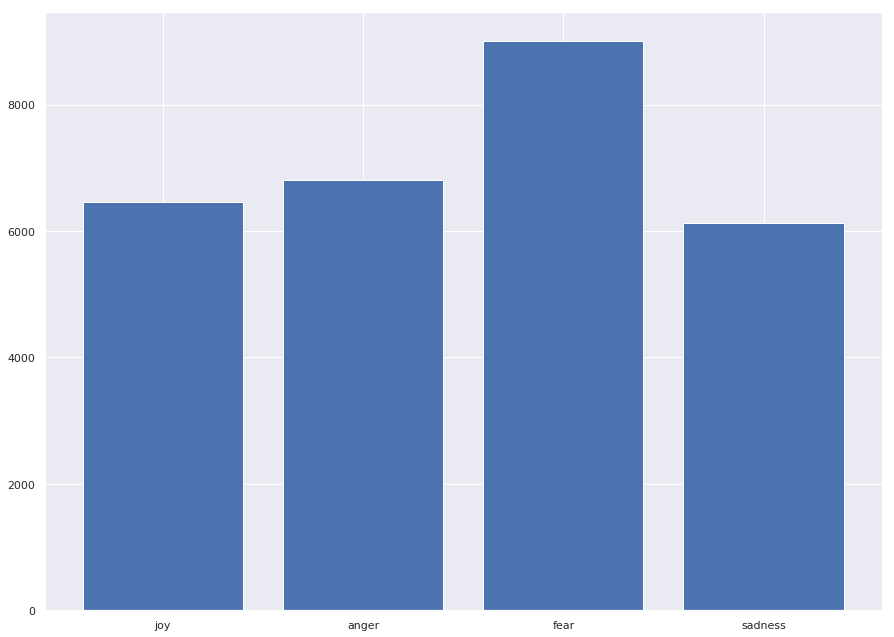

In [93]:
vocabulary_size = 9000
tokenizer = Tokenizer(num_words= 1000)
tokenizer.fit_on_texts(df['Tweet'])
word2index = tokenizer.word_index
index2word = {i:j for i, j in enumerate(word2index)}
emotions = df['Affect Dimension'].unique()
sum_categorical_emotions = [df[df['Affect Dimension'] == i].size for i in emotions]
plt.bar(emotions, sum_categorical_emotions)
plt.show()

**Preprocess the Datasets**

This process aims to clear the datasets before being used by the training process. Here i clear (punctuation, @, #, URL, username, etc). And implement NLTK Stemming and stopwords to  get the better result.

In [0]:
#Preprocess the data using stopwords and stemming
stopwords = nltk.corpus.stopwords.words('english')
stemmer = PorterStemmer()
with open("/content/drive/My Drive/Colab Notebooks/Sentiment/stopword_list_TALA.txt", "r") as ins:
    array = []
    for line in ins:
        array.append(line)
lst = [array.strip() for array in array]
for i in lst:
    stopwords.append(i)
    
def tweet_filter(tweet):
  tweet = tweet.lower()
  tweet = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet)
  tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)
  tweet = re.sub(r'@[^\s]+', 'AT_USER', tweet)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  tweet = re.sub(r'\brt\b', '', tweet)
  tweet = re.sub(r'\buser\b', '', tweet)
  tweet = re.sub(r'\burl\b', '', tweet)
  tweet = tweet.replace("\n","")
  tweet = re.sub(r'\.{2,}', ' ', tweet)
  tweet = tweet.strip(' "\'')
  tweet = re.sub(r'\s+', ' ', tweet)
  
  tweet = stemmer.stem(tweet)
  tweet = word_tokenize(tweet)
  return [word for word in tweet if word not in stopwords]

In [95]:
x_data = []
x = df['Tweet']
x = x.apply(tweet_filter)
for i in x:
  x_data.append(i)
print(x_data)

[['kirby', 'black', 'panther', 'cool', 'animated', 'panel'], ['fury', 'road'], ['photographer', 'portrait', 'shooting', 'mode', 'iphone', '7', 'plus', 'going', 'frustrate', '75', 'time', 'delight', '25', 'tim'], ['heads', 'melted', 'tired', 'sleep'], ['baily', 'always', 'happy', 'support', 'brother', 'keep', 'fire', 'burning', 'lt', '3'], ['dropped', 'phone', 'sink', 'earlier', 'sound', 'everythin', 'else', 'works', 'prepared', 'life', 'without', 'music', 'put', 'earphones'], ['well', 'evaluation', 'came', 'back', 'minimally', 'effective', 'student', 'test', 'scores', 'parcc', 'sunk', 'eval', 'time', 'quit', 'teach'], ['15', 'doe', 'run', 'opposite', 'side'], ['magpies', 'gathering', 'around', 'help', 'going', 'swooped', 'terror'], ['provoke', 'ang'], ['job', 'interview', 'loughborough', 'next', 'month', 'nerv'], ['got', 'asked', 'hoco', 'instagram', 'dm', 'bc', 'someone', 'lost', 'bet', 'love', 'maturity', 'people', 'grad'], ['ever', 'really', 'lonely', 'phone', 'keeps', 'blowing', 'p

This steps can also be considered as preprocessed step, but the main purpose is slightly different. This steps transform text datasets into numerical vector, so i can create machine learning model for training.

In [96]:
sequences = tokenizer.texts_to_sequences(x_data)
data = pad_sequences(sequences, maxlen=50)
X = data.reshape(len(data), 50)
X[100]

flag = pd.Series(list(df['Affect Dimension']))
Y = pd.get_dummies(flag)
Y = np.array(Y)
Y[100]

array([1, 0, 0, 0], dtype=uint8)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

**Defining LSTM Model and Training Process**

In [98]:
inputs = Input(shape=[50])
layer = Embedding(100000, 500, input_length=50)(inputs)
layer = LSTM(512)(layer)
layer = Dense(256)(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(4)(layer)
layer = Activation('softmax')(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 500)           50000000  
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2074624   
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 1028      
__________

In [99]:
model.fit(X_train, y_train, batch_size=256, epochs=25, validation_data=(X_test, y_test), shuffle=True)

Train on 4758 samples, validate on 2344 samples
Epoch 1/25
4758/4758 [==============================] - 9s 2ms/step - loss: 1.3604 - acc: 0.3243 - val_loss: 1.3072 - val_acc: 0.5209
Epoch 2/25
4758/4758 [==============================] - 6s 1ms/step - loss: 1.0443 - acc: 0.6200 - val_loss: 0.8403 - val_acc: 0.6911
Epoch 3/25
4758/4758 [==============================] - 6s 1ms/step - loss: 0.6106 - acc: 0.7718 - val_loss: 0.7219 - val_acc: 0.7253
Epoch 4/25
4758/4758 [==============================] - 6s 1ms/step - loss: 0.4554 - acc: 0.8211 - val_loss: 0.7048 - val_acc: 0.7487
Epoch 5/25
4758/4758 [==============================] - 6s 1ms/step - loss: 0.3934 - acc: 0.8522 - val_loss: 0.7266 - val_acc: 0.7351
Epoch 6/25
4758/4758 [==============================] - 6s 1ms/step - loss: 0.3579 - acc: 0.8638 - val_loss: 0.7739 - val_acc: 0.7509
Epoch 7/25
4758/4758 [==============================] - 6s 1ms/step - loss: 0.3461 - acc: 0.8644 - val_loss: 0.8131 - val_acc: 0.7457
Epoch 8/25
475

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/Emotion/codalab/El-oc/train/model.h5')

**PREPARING FOR TESTING AND EVALUATION**

In [101]:
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Emotion/codalab/El-oc/test/joy-test.csv', encoding='utf-8')
df_test.drop(['ID', 'Intensity Class'], axis = 1, inplace = True)
df_test.head()

,Tweet,Affect Dimension
0,People are truly #amazing. #inspiring day,joy
1,What are some good #funny #entertaining #inter...,joy
2,@NoahWebHouse A review of my book faulted me f...,joy
3,#good to learning #wisdom &lt;&lt; reform (v):...,joy
4,"Really excited to see our team this year, and ...",joy


In [107]:
ran = rand.choice(list(df_test['Tweet']))
print(ran)
sequences = tokenizer.texts_to_sequences([ran])
data = pad_sequences(sequences, maxlen=50)
y = model.predict(data)
y = np.argmax(y)
print(emotions[y])


di happy sa life pero may wattpad to fulfill the happiness HAHAHA
joy


**CLASSIFICATION REPORT**

[Text(0, 0.5, 'joy'),
 Text(0, 1.5, 'sadness'),
 Text(0, 2.5, 'fear'),
 Text(0, 3.5, 'anger')]

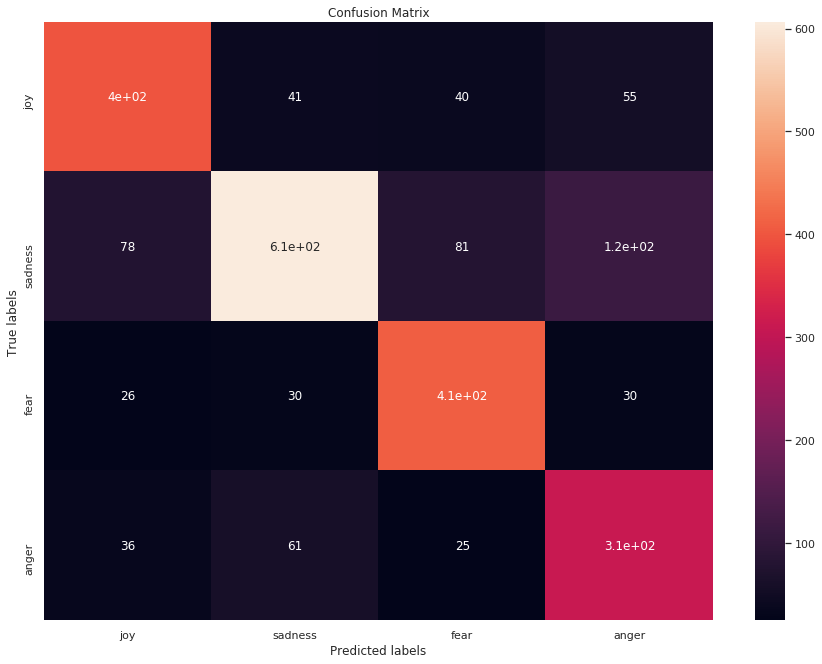

In [108]:
y_predict = model.predict(X_test)
predict = np.argmax(y_predict, axis = 1)
y_test_class = np.argmax(y_test, axis = 1)
cm = confusion_matrix(predict, y_test_class)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
sns.set(rc={'figure.figsize':(15, 11)})
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(emotion)
ax.yaxis.set_ticklabels(emotion)

In [109]:
precision, recall, fscore, support = score(y_test_class, predict)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('emotion: {}'.format(emotions))

precision: [0.74579439 0.68863636 0.8266129  0.7182448 ]
recall: [0.74025974 0.82113821 0.73741007 0.60861057]
fscore: [0.74301676 0.74907293 0.77946768 0.65889831]
support: [539 738 556 511]
emotion: ['joy' 'anger' 'fear' 'sadness']


In [110]:
score_table = PrettyTable(['Emotion', 'Precision', 'Recall', 'F-score', 'Support'])
for i in range(0, len(emotion)):
    score_table.add_row([emotions[i], precision[i], recall[i], fscore[i], support[i]])
print(score_table)

+---------+--------------------+--------------------+--------------------+---------+
| Emotion |     Precision      |       Recall       |      F-score       | Support |
+---------+--------------------+--------------------+--------------------+---------+
|   joy   | 0.7457943925233644 | 0.7402597402597403 | 0.7430167597765364 |   539   |
|  anger  | 0.6886363636363636 | 0.8211382113821138 | 0.7490729295426451 |   738   |
|   fear  | 0.8266129032258065 | 0.737410071942446  | 0.7794676806083651 |   556   |
| sadness | 0.7182448036951501 | 0.6086105675146771 | 0.6588983050847458 |   511   |
+---------+--------------------+--------------------+--------------------+---------+
